

===== Estos son los nulls de train =====

size            306775
type            191640
condition       191021
paint_color     189613
cylinders       188076
drive           180334
odometer        153465
manufacturer     37260
make             19078
weather          16182
state_fips       16009
county_name      16009
county_fips      16009
state_code       16009
fuel              2844
transmission      2447
year              1713
title_status       708
city                 0
price                0
lat                  0
long                 0
state_name           0
Id                   0
dtype: int64


===== Matriz de correlación =====



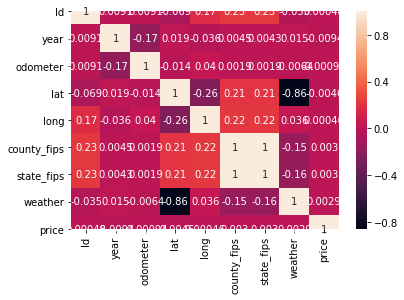


No hay variables con alto grado de correlación (>0.9), por lo que no podemos eliminar variables por correlación.


===== Boxplot de la variable price =====


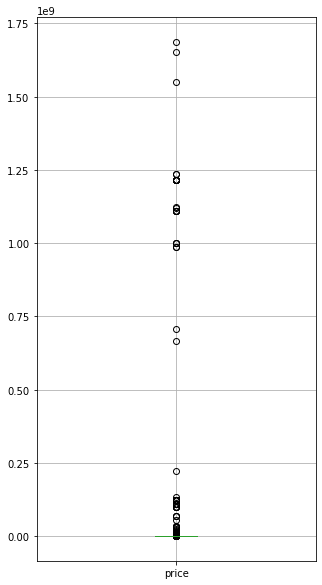



===== Resumen de eliminación de variables de cara al modelo =====


        Eliminamos:
        - las variables no significativas resultantes del ANOVA
        - 'state_code', 'state_fips' ya que son redundantes con state_name
        - variables con muchos nulls
        - variables categóricas con muchos valores únicos
        - 'lat', 'long' no son determinantes la una sin la otra

        
        En definitiva, se eliminan las siguientes variables:

        ['Id','paint_color', 'drive', 'size', 'fuel', 'manufacturer', 'type', 'condition', 'title_status',

        'city', 'make', 'odometer', 'lat', 'long', 'county_fips', 'county_name', 'state_code', 'state_fips']
        

No es necesario unificar la dimensión.


===== Se rescalan X_train, X_test ======

Se ha rescalado con StandardScaler
Se ha rescalado con StandardScaler


===== Modelos de entrenamiento ======

Se ha entrenado el modelo LinearRegression


===== The submission files are ready in the outputs folder! =====


In [4]:
import extractor, explorer, cleaner, transformer, spliter, scaler, dim_reductor, trainer, loader
import pandas as pd


def extract():
    cars_train = extractor.extract_csv('cars_train.csv')
    cars_test = extractor.extract_csv('cars_test.csv')
    return cars_train, cars_test


def explore(train):
    #insignificant_cols = explorer.get_anova_conclusions(train)
    #Cuando termine de probar, tengo que eliminar la siguiente fila y dejar la anterior.
    insignificant_cols = ['manufacturer', 'condition', 'fuel', 'title_status', 'drive', 
                          'size', 'type', 'paint_color', 'state_name']
    explorer.get_nulls_conclusions(train)
    explorer.get_correlation_conclusions(train)
    explorer.plot_price_outliers(train)
    return insignificant_cols


def clean(train, test, insignificant_cols):
    clean_train, clean_test = cleaner.remove_cols(train, test, insignificant_cols)
    clean_train = cleaner.remove_nans(clean_train)
    clean_test = cleaner.fill_nans(clean_test)
    return clean_train, clean_test


def transform(train, test):
    try:
        train = transformer.transform_cylinders(train)
        test = transformer.transform_cylinders(test)
    except:
        print("\nNo hay cylinders en el dataframe.")
    final_train = transformer.one_hot_encode(train)
    final_test = transformer.one_hot_encode(test)
    try:
        final_test = transformer.unify_dimension(train, test, final_test)
    except:
        print("\nNo es necesario unificar la dimensión.")
    return final_train, final_test
    

def train_split(train):
    X_train, y_train = spliter.split_train(train)
    return X_train, y_train


def rescale(X_train, X_test):
    """
    Es recomendable rescalar las variables de cara a entrenar el modelo.
    No obstante, en mi último entrenamiento he observado que afecta negativamente al modelo.
    Por ello, he comentado la línea en el main.
    """
    print("\n\n===== Se rescalan X_train, X_test ======\n")
    scaled_X_train = scaler.standard_scaler(X_train) # Hay que elegir entre uno de los métodos de rescale.
    scaled_X_test = scaler.standard_scaler(X_test) # Hay que elegir entre uno de los métodos de rescale.
    return scaled_X_train, scaled_X_test


def reduce_dimension(X_train, X_test):
    X_train_pc, X_test_pc = dim_reductor.data_to_pca(X_train, X_test)
    return X_train_pc, X_test_pc


def train_and_predict(X_train, y_train, X_test):
    print("\n\n===== Modelos de entrenamiento ======\n")
    model_results = []
    model_results.append(trainer.linear_regression(X_train, y_train, X_test))
    #model_results.append(trainer.random_forest(X_train, y_train, X_test))
    #model_results.append(trainer.decision_tree(X_train, y_train, X_test))
    #model_results.append(trainer.kneighbors(X_train, y_train, X_test))
    #model_results.append(trainer.gradient_boosting(X_train, y_train, X_test))
    return model_results

    
def load(model_results, test):
    for result in model_results:
        y_pred = result[0]
        name = result[1]
        submission = loader.create_submission(y_pred, test)
        loader.load_csv(submission, "cars_submission_"+name+".csv")


    

def main():
    train, test = extract()
    insignificant_cols = explore(train)
    clean_train, clean_test = clean(train, test, insignificant_cols)
    final_train, X_test = transform(clean_train, clean_test)
    X_train, y_train = train_split(final_train)
    X_train, X_test = rescale(X_train, X_test) # No siempre conviene. Aparte de los dummies, tengo muy pocas variables numéricas.
    #if clean_train.shape[1]>3:
    #    X_train, X_test = reduce_dimension(X_train, X_test) # No funciona para mi X. No tiene muchas variables numéricas.
    model_results = train_and_predict(X_train, y_train, X_test)
    load(model_results, test)
    print("\n\n===== The submission files are ready in the outputs folder! =====")

    
if __name__ == "__main__":
    main()